# MIE 1517 Group Project

Chin Ming Wong

Zijie Zhao

Peng Yang

Yunqing Tang

# Project Overview

This project is designed to leverge on different neural network architechtures to classify multiple Avenger characters from a large set of human images.

In Part 1 we decided to classify Avengers and Non-Avengers images. We build CNN architechture classifier, followed by taking advantage of transfer learning.

In Part 2 we would like to classify which specific Avengers those images that were classified as Avengers belong to. We built CNN architecture classifier, followed by transfer learning of AlexNet and other possible pretrained nets, to improve model performance.

# Import Libraries

In [3]:
# Import libraries
import os
import numpy as np
import torch
import shutil
import PIL
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, models, transforms
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

torch.manual_seed(1) # Set the random seed

In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# GPU
use_cuda = True 

# Part 1. Avengers & Non-Avengers Classifier

## Raw Data Exploration

In [18]:
# Data loading
data_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module1'
data_transform = transforms.Compose([transforms.ToTensor()])
raw_data = datasets.ImageFolder(data_dir, transform = data_transform)
print('Number of images: ', len(raw_data))

Number of images:  8130


In [10]:
# Check dimensions of a single image
raw_data[1][0].shape

torch.Size([3, 788, 713])

490 517 RGB JPEG <class 'PIL.JpegImagePlugin.JpegImageFile'>


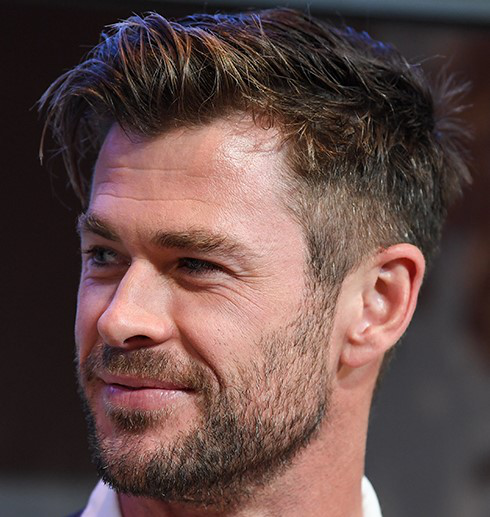

In [11]:
im = PIL.Image.open(data_dir + '/Avengers/1-1.jpg')
print(im.width, im.height, im.mode, im.format, type(im))
display(im)

## Data Preprocessing

### Data Splitting

Split the data into train, validation set, the splitting ratio is 0.8. The test set will be collected and tested on the final model. The dataset here are used for training and validation purposes only.

In [ ]:
# Split current data set into 2 folders, namely train and val

def train_val_split(classes, train_ratio = 0.8, val_ratio = 0.2):
  from_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module1/' # Directory of the original data
  root_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module1/Data Split/' # Root directory of the new arranged data 

  for cls in classes:
    class_dir = from_dir + cls # The folder to look for the images of each letter
    img_names = os.listdir(class_dir) # Get the file names of the images

    # Check if there is a train, val, and test folder and make one if not
    if os.path.isdir(root_dir + '/train//') is False:
      os.makedirs(root_dir + '/train//')
    if os.path.isdir(root_dir + '/train//' + cls) is False:
      os.makedirs(root_dir + '/train//' + cls)

    if os.path.isdir(root_dir + '/val//') is False:
      os.makedirs(root_dir + '/val//')
    if os.path.isdir(root_dir + '/val//' + cls) is False:
      os.makedirs(root_dir + '/val//' + cls)

    # Splitting the data
    train, val = np.split(img_names, [int(len(img_names)*train_ratio)])

    # Get the file names and split into each set
    train_names = [class_dir + '/' + name for name in train]
    val_names = [class_dir + '/' + name for name in val]

    print('For {}:'.format(cls))
    print('Total number of images: ', len(img_names))
    print('Total number of training images: ', len(train_names))
    print('Total number of validation images: ', len(val_names))
    print('\n')

    # Copy the images to the new folders
    for file_name in train_names:
      shutil.copy(file_name, root_dir + '/train//' + cls)
    for file_name in val_names:
      shutil.copy(file_name, root_dir + '/val//' + cls)


# Set up classes and ratios
classes = ['Avengers', 'Non-Avengers'] 
train_ratio = 0.8
val_ratio = 0.2

train_val_split(classes, train_ratio, val_ratio)

### Data Preparation

Load the train, validation set using ImageFolder function. Check the number of images in each set. Finally, visualize some training data.

In [19]:
# Data loading & transformation

# Set up data directory
data_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module1/Data Split/'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')

# Ensure all images are 224 x 224 by resizing them
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform = data_transform)
val_data = datasets.ImageFolder(val_dir, transform = data_transform)

# Check number of images
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))

Number of training images:  3252
Number of validation images:  813


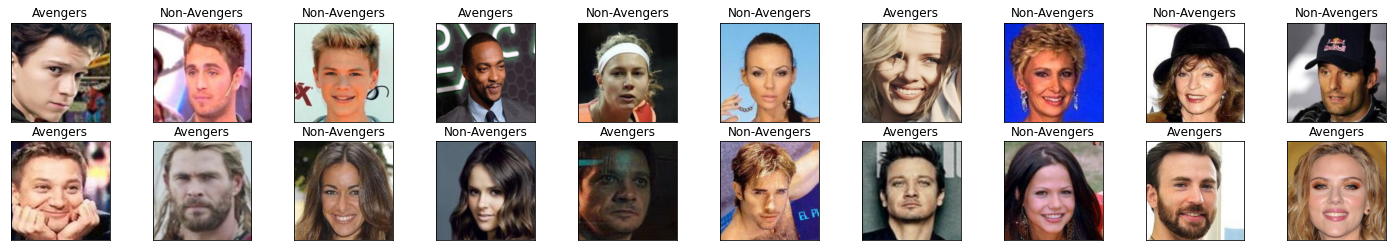

In [20]:
# Visualize some of the training data
classes = ['Avengers', 'Non-Avengers']
data_loader = torch.utils.data.DataLoader(train_data, batch_size = 20, shuffle = True)

# Obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Modelling

### Model 1: CNN

Using 2 convolution layers, 2 max poolings, and 2 fully connencted layers in the architecture below.

In [21]:
class CNN1(nn.Module):
      def __init__(self):
          self.name = "CNN1"
          super(CNN1, self).__init__()
          self.conv1 = nn.Conv2d(3, 5, 5) 
          self.pool = nn.MaxPool2d(2, 2) 
          self.conv2 = nn.Conv2d(5, 10, 5) 
          self.fc1 = nn.Linear(28090, 1000)
          self.fc2 = nn.Linear(1000, 2)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x))) 
          x = self.pool(F.relu(self.conv2(x))) 
          x = x.view(-1, 28090)
          x = F.relu(self.fc1(x)) 
          x = self.fc2(x)
          return x

In [22]:
def get_accuracy(model, loader, use_cuda = False):

    correct = 0
    total = 0
    for imgs, labels in loader:
        
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)     
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Use checkpointing to save parameters.

In [23]:
def check_point(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [28]:
def train(model, data, batch_size = 64, num_epochs = 1, learning_rate = 0.01, use_cuda = False, use_val = True):

    # Load training and validation data
    train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = True)
    if use_val:
      val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # Training
    n = 0 # The number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # Forward pass
            loss = criterion(out, labels) # Compute the total loss
            loss.backward()               # Backward pass (compute parameter updates)
            optimizer.step()              # Make the updates for each parameter
            optimizer.zero_grad()         # A clean up step for PyTorch

            # Save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size) # Compute *average* loss
            train_acc.append(get_accuracy(model, train_loader, use_cuda)) # Compute training accuracy
            if use_val: 
              val_acc.append(get_accuracy(model, val_loader, use_cuda))  # Compute validation accuracy
            n += 1

      # Save the current model (checkpoint) to a file every 20 epoch and final epoch
      
        if (epoch+1)%2 == 0:
          print('~~~~This is epoch: ', epoch+1)
          model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)  
        elif (epoch+1) == num_epochs:
          model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path) 
          print('epoch: ', epoch+1) 
         
    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if use_val:
      plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if use_val:
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

#### Sanity Check

Building the sanity check to see if the model can overfit to the smaller dataset.

CUDA is available!  Training on GPU ...
epoch:  5
epoch:  10
epoch:  15
epoch:  20
epoch:  25
epoch:  30
epoch:  35
epoch:  40
epoch:  45
epoch:  50
epoch:  55
epoch:  60


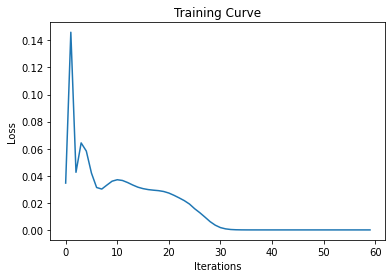

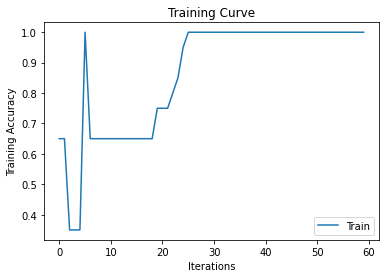

Final Training Accuracy: 1.0


In [27]:
np.random.seed(9)
data_subset = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), 20, replace = False)) # Get a small set of images from training dataset

model = CNN1()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(model, data_subset, batch_size = 20, num_epochs = 60, learning_rate = 0.001, use_cuda = use_cuda, use_val = False)

#### Training

CUDA is available!  Training on GPU ...
~~~~This is epoch:  2
~~~~This is epoch:  4
~~~~This is epoch:  6
~~~~This is epoch:  8
~~~~This is epoch:  10
~~~~This is epoch:  12
~~~~This is epoch:  14
~~~~This is epoch:  16
~~~~This is epoch:  18
~~~~This is epoch:  20
~~~~This is epoch:  22
~~~~This is epoch:  24
~~~~This is epoch:  26
~~~~This is epoch:  28
~~~~This is epoch:  30
~~~~This is epoch:  32
~~~~This is epoch:  34
~~~~This is epoch:  36
~~~~This is epoch:  38
~~~~This is epoch:  40
~~~~This is epoch:  42
~~~~This is epoch:  44
~~~~This is epoch:  46
~~~~This is epoch:  48
~~~~This is epoch:  50


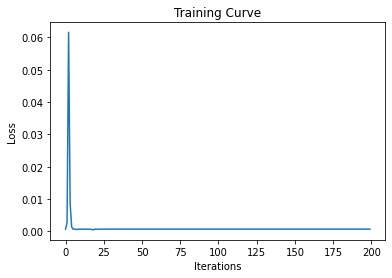

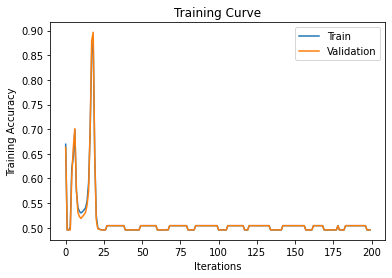

Final Training Accuracy: 0.4956949569495695
Final Validation Accuracy: 0.4956949569495695


In [29]:
model = CNN1()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_data, batch_size=1024, num_epochs=50, learning_rate=0.01, use_cuda=use_cuda)

### Model 2: Transfer learning

#### a) AlexNet

In [32]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
feature_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module1/Alex Features/'

if os.path.isdir(feature_dir) is False:
      os.makedirs(feature_dir)

In [ ]:
def save_features(data,batch_size,data_name):
    n = 1
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True):

        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        features = alexnet.features(imgs)

        data_path = feature_dir+get_data_name(data_name, batch_size,n)
        label_path = feature_dir+get_data_name(data_name, batch_size,n)+"label"
        torch.save(features, data_path)
        torch.save(labels, label_path)
        n+=1

def get_data_name(name, batch_size,n):
    """ Generate a name for the data with batch size
    """
    path = "data_{0}_bs{1}_{2}.pt".format(name,batch_size,n)
    return path

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  alexnet = alexnet.cuda()

save_features(train_data,1024,"train")
save_features(val_data,1024,"val")
save_features(train_data,512,"train")
save_features(val_data,512,"val")
save_features(train_data,32,"train")
save_features(val_data,32,"val")

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
# output = model(features)
# prob = F.softmax(output)

class TCNNClassifier(nn.Module):
    def __init__(self):
        super(TCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 50,2)
        self.conv2 = nn.Conv2d(50, 10,2)
        self.fc1 = nn.Linear(160,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# tensor = torch.from_numpy(tensor.detach().numpy())
def get_accuracy(model,data_loader,batch_size,train = True):
    correct = 0
    total = 0
    k = 1
    for imgs, labels in data_loader:
        if train:
          file_name = feature_dir + get_data_name("train", batch_size,k)
          label_name = feature_dir + get_data_name("train", batch_size,k)+"label"
        else:
          file_name = feature_dir + get_data_name("val", batch_size,k)
          label_name = feature_dir + get_data_name("val", batch_size,k)+"label"
        k += 1

        imgs = torch.load(file_name)
        labels = torch.load(label_name)

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, data, batch_size, num_epochs,lr,printed = True):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=0, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                             num_workers=0, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    ###optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        k = 1
        for imgs, labels in iter(train_loader):

            file_name = feature_dir + get_data_name("train", batch_size,k)
            label_name = feature_dir + get_data_name("train", batch_size,k)+"label"

            k += 1
            imgs = torch.load(file_name)
            labels = torch.load(label_name)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            training_accuracy = get_accuracy(model, train_loader,batch_size,train=True)
            train_acc.append(training_accuracy) # compute training accuracy 
            validation_accuracy = get_accuracy(model, val_loader,batch_size,train=False)
            val_acc.append(validation_accuracy)  # compute validation accuracy

            if printed:
              print("Iteration "+str(n)+":")
              print("CE Loss:" + str(float(loss)/batch_size))
              print("Training Accuracy = "+str(training_accuracy))
              print("Validation Accuracy = "+str(validation_accuracy))
            
            n += 1
    alex_model_path = model_path + "alex_bs{0}_lr{1}_epoch{2}".format(batch_size,
                                                   lr,
                                                   num_epochs)
    torch.save(model.state_dict(), alex_model_path)


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Training Model:batch_size = 1024, num_epochs = 5, lr = 0.01
Iteration 0:
CE Loss:0.0013549304567277431
Training Accuracy = 0.5018450184501845
Validation Accuracy = 0.4944649446494465
Iteration 1:
CE Loss:0.001353057217784226
Training Accuracy = 0.5021525215252153
Validation Accuracy = 0.4981549815498155
Iteration 2:
CE Loss:0.0013526641996577382
Training Accuracy = 0.507380073800738
Validation Accuracy = 0.5030750307503075
Iteration 3:
CE Loss:0.0013534057652577758
Training Accuracy = 0.5178351783517835
Validation Accuracy = 0.5067650676506765
Iteration 4:
CE Loss:0.0013489752309396863
Training Accuracy = 0.5289052890528906
Validation Accuracy = 0.5153751537515375
Iteration 5:
CE Loss:0.0013498133048415184
Training Accuracy = 0.5439729397293973
Validation Accuracy = 0.5239852398523985
Iteration 6:
CE Loss:0.001344681833870709
Training Accuracy = 0.5571955719557196
Validation Accuracy = 0.5387453874538746
Iteration 7:
CE Loss:0.001348376157693565


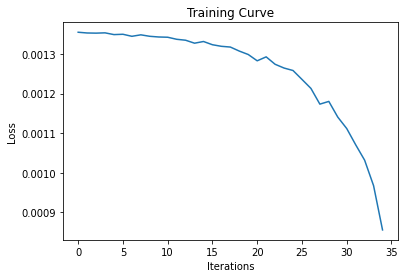

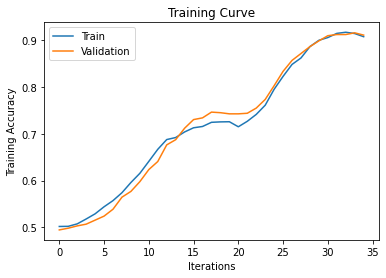

Final Training Accuracy: 0.9080565805658056
Final Validation Accuracy: 0.9114391143911439


In [ ]:
use_cuda = True

model = TCNNClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
print("Training Model:batch_size = 1024, num_epochs = 5, lr = 0.01")
train(model, train_data, batch_size = 512, num_epochs = 5,lr = 0.01)

# Part 2. Avengers Classifier

## Raw Data Exploration

Data loading and exploring.

In [5]:
# Data loading
data_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2'
data_transform = transforms.Compose([transforms.ToTensor()])
raw_data = datasets.ImageFolder(data_dir, transform = data_transform)
print('Number of images: ', len(raw_data))

Number of images:  4100


In [6]:
# Check dimensions of a single image
raw_data[1][0].shape

torch.Size([3, 623, 533])

302 320 RGB JPEG <class 'PIL.JpegImagePlugin.JpegImageFile'>


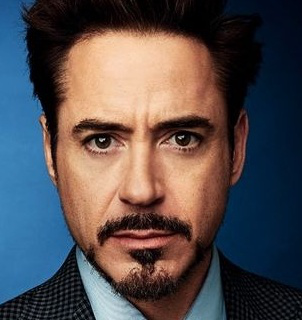

In [7]:
im = PIL.Image.open(data_dir + '/Robert Downey Jr/Robert Downey Jr8_4304.jpg')
print(im.width, im.height, im.mode, im.format, type(im))
display(im)

In [ ]:
# Get dimensions of all images
dims = torch.tensor([raw_data[i][0].shape for i in range(len(raw_data))])
print(len(dims))

In [ ]:
# Check the number of different dimensions
for i in range(3):
  unique, num = torch.unique(dims[:, i], sorted = True, return_counts = True) # Number of unique values in each dim
  print('For dim', i)
  print('Unique values: ', unique)
  print('Number of unique values: ', len(unique))
  print('Number in each unique value: ', num)
  print('\n')


For dim 0
Unique values:  tensor([3])
Number of unique values:  1
Number in each unique value:  tensor([2050])


For dim 1
Unique values:  tensor([  82,   89,   97,  105,  108,  119,  128,  129,  140,  145,  146,  152,
         154,  155,  158,  167,  168,  171,  173,  182,  183,  184,  185,  186,
         189,  190,  191,  193,  194,  196,  199,  200,  201,  202,  204,  206,
         208,  211,  213,  218,  220,  221,  223,  225,  226,  233,  235,  236,
         237,  239,  240,  241,  243,  250,  251,  256,  258,  264,  266,  268,
         270,  274,  280,  281,  284,  290,  291,  292,  293,  294,  298,  299,
         300,  304,  313,  315,  316,  320,  322,  331,  334,  336,  339,  344,
         348,  349,  350,  353,  355,  359,  360,  362,  363,  374,  375,  380,
         386,  387,  394,  398,  399,  400,  402,  404,  406,  408,  410,  420,
         421,  423,  428,  430,  435,  437,  438,  440,  448,  450,  456,  461,
         462,  463,  466,  475,  480,  482,  483,  490,  493,

## Data Preprocessing

### Data Splitting (only run once)

Split the data into train and validation set, the splitting ratio is 0.8. The test set will be collected and tested on the final model. The dataset here are used for training and validation only. The number of images for different Avenger actors in the data set is also determined.

In [ ]:
# Split current data set into 2 folders, namely train and val

def train_val_split(classes, train_ratio = 0.8, val_ratio = 0.2):
  from_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/' # Directory of the original data
  root_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/Data Split/' # Root directory of the new arranged data 

  for cls in classes:
    class_dir = from_dir + cls # The folder to look for the images of each letter
    img_names = os.listdir(class_dir) # Get the file names of the images

    # Check if there is a train, val, and test folder and make one if not
    if os.path.isdir(root_dir + '/train//') is False:
      os.makedirs(root_dir + '/train//')
    if os.path.isdir(root_dir + '/train//' + cls) is False:
      os.makedirs(root_dir + '/train//' + cls)

    if os.path.isdir(root_dir + '/val//') is False:
      os.makedirs(root_dir + '/val//')
    if os.path.isdir(root_dir + '/val//' + cls) is False:
      os.makedirs(root_dir + '/val//' + cls)

    # Splitting the data
    train, val = np.split(img_names, [int(len(img_names)*train_ratio)])

    # Get the file names and split into each set
    train_names = [class_dir + '/' + name for name in train]
    val_names = [class_dir + '/' + name for name in val]

    print('For {}:'.format(cls))
    print('Total number of images: ', len(img_names))
    print('Total number of training images: ', len(train_names))
    print('Total number of validation images: ', len(val_names))
    print('\n')

    # Copy the images to the new folders
    for file_name in train_names:
      shutil.copy(file_name, root_dir + '/train//' + cls)
    for file_name in val_names:
      shutil.copy(file_name, root_dir + '/val//' + cls)


# Set up classes and ratios
classes = ['Anthony Mackie', 'Chris Evans', 'Chris Hemsworth', 
           'Elizabeth Olsen', 'Jeremy Renner', 'Mark Ruffalo', 
           'Robert Downey Jr', 'Scarlett Johansson', 'Tom Hiddleston',
           'Tom Holland'] # Avengers (the "well-known" ones)
train_ratio = 0.8
val_ratio = 0.2

train_val_split(classes, train_ratio, val_ratio)

For Anthony Mackie:
Total number of images:  197
Total number of training images:  157
Total number of validation images:  40


For Chris Evans:
Total number of images:  207
Total number of training images:  165
Total number of validation images:  42


For Chris Hemsworth:
Total number of images:  202
Total number of training images:  161
Total number of validation images:  41


For Elizabeth Olsen:
Total number of images:  208
Total number of training images:  166
Total number of validation images:  42


For Jeremy Renner:
Total number of images:  207
Total number of training images:  165
Total number of validation images:  42


For Mark Ruffalo:
Total number of images:  210
Total number of training images:  168
Total number of validation images:  42


For Robert Downey Jr:
Total number of images:  214
Total number of training images:  171
Total number of validation images:  43


For Scarlett Johansson:
Total number of images:  202
Total number of training images:  161
Total number of

### Data Preparation

Resize data into 224 x 224 and load them by ImageFolder function. Some training data are visualized here.

In [18]:
# Data loading & transformation

# Set up data directory
data_dir = '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/Data Split/'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')

# Ensure all images are 224 x 224 by resizing them
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform = data_transform)
val_data = datasets.ImageFolder(val_dir, transform = data_transform)

# Check number of images
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))

Number of training images:  1636
Number of validation images:  414


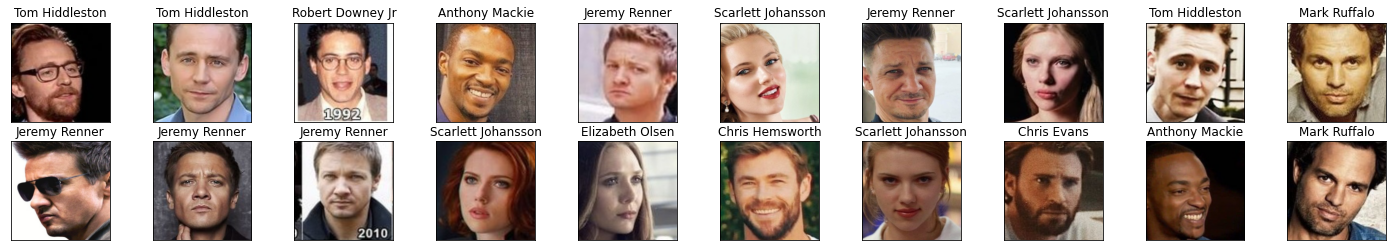

In [19]:
# Visualize some of the training data
classes = ['Anthony Mackie', 'Chris Evans', 'Chris Hemsworth', 
           'Elizabeth Olsen', 'Jeremy Renner', 'Mark Ruffalo', 
           'Robert Downey Jr', 'Scarlett Johansson', 'Tom Hiddleston',
           'Tom Holland']
data_loader = torch.utils.data.DataLoader(train_data, batch_size = 20, shuffle = True)

# Obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Modelling

### Model 1: Self-written CNN

Used 2 convolution layers, 2 max pooling and 3 fully connencted layers in the architecture below.

In [ ]:
# Build model
class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.name = 'CNN'
          self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 9, kernel_size = 2, stride = 2, padding = 0)
          self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
          self.conv2 = nn.Conv2d(9, 18, 2, 2)
          self.conv3 = nn.Conv2d(18, 36, 2, 2)
          self.fc1 = nn.Linear(36*7*7, 1000)
          self.fc2 = nn.Linear(1000, 1000)
          self.fc3 = nn.Linear(1000, 10) # 10 actors/actresses

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.conv3(x)
          x = x.view(-1, 36*7*7)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
def get_accuracy(model, loader, use_cuda = False):

    correct = 0
    total = 0
    for imgs, labels in loader:
        
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)     
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def check_point(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train(model, data, batch_size = 64, num_epochs = 1, learning_rate = 0.01, use_cuda = False, use_val = True):

    # Load training and validation data
    train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = True)
    if use_val:
      val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # Training
    n = 0 # The number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # Forward pass
            loss = criterion(out, labels) # Compute the total loss
            loss.backward()               # Backward pass (compute parameter updates)
            optimizer.step()              # Make the updates for each parameter
            optimizer.zero_grad()         # A clean up step for PyTorch

            # Save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size) # Compute *average* loss
            train_acc.append(get_accuracy(model, train_loader, use_cuda)) # Compute training accuracy
            if use_val: 
              val_acc.append(get_accuracy(model, val_loader, use_cuda))  # Compute validation accuracy
            n += 1

      # Save the current model (checkpoint) to a file every 20 epoch and final epoch
      
        if (epoch+1)%20 == 0:
          print('epoch: ', epoch+1)
          model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path)  
        elif (epoch+1) == num_epochs:
          model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
          torch.save(model.state_dict(), model_path) 
          print('epoch: ', epoch+1) 
         
    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if use_val:
      plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if use_val:
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

#### Overfitting Test

Build the sanity check to see if the model can overfit to the smaller dataset.

In [ ]:
# Test model on a small dataset

np.random.seed(9)
data_subset = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), 10, replace = False)) # Get a small set of images from training dataset

model = CNN()
if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, data_subset, batch_size = 10, num_epochs = 100, learning_rate = 0.01, use_cuda = use_cuda, use_val = False)

A balanced small dataset of 10 images was used for the sanity check. The sanity check successfully shows that the model is able to overfit to the small dataset, which indicates that the model is able to learn different actors in the Avengers.

#### Training

In [ ]:
# Initial
model = CNN()
if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, train_data, batch_size = 256, num_epochs = 50, learning_rate = 0.001, use_cuda = use_cuda)

In [ ]:
# Batch size increased

model = CNN()
if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, train_data, batch_size = 1024, num_epochs = 50, learning_rate = 0.001, use_cuda = use_cuda)

In [ ]:
# Save the best model
model_1 = CNN()
model_path = check_point(model_1.name, batch_size = 1024, learning_rate = 0.001, epoch = 50)
state_1 = torch.load(model_path)
model_1.load_state_dict(state_1)

### Model 2: Transfer Learning

In [ ]:
import torchvision.models

#### a) AlexNet

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

# Compute AlexNet features

def alex_features(data, use_cuda = False):
  loader = torch.utils.data.DataLoader(data, batch_size = len(data), shuffle = True)
  dataiter = iter(loader)
  imgs, labels = dataiter.next()

  #############################################
  # To Enable GPU Usage
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
    alexnet.cuda()
  #############################################

  features = alexnet.features(imgs)
  print(features.shape, labels.shape)
  
  return features, labels

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Compute features for training and validation data
train_features, train_labels = alex_features(train_data, use_cuda)
val_features, val_labels = alex_features(val_data, use_cuda)

torch.Size([1636, 256, 6, 6]) torch.Size([1636])
torch.Size([414, 256, 6, 6]) torch.Size([414])


In [ ]:
# Save computed features and labels
torch.save(train_features, '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/train_features_alexnet.pt')
torch.save(train_labels, '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/train_labels_alexnet.pt')

torch.save(val_features, '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/val_features_alexnet.pt')
torch.save(val_labels, '/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/val_labels_alexnet.pt')

In [ ]:
# Load features
train_features = torch.load('/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/train_features_alexnet.pt)
train_labels = torch.load('/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/train_labels_alexnet.pt')

val_features = torch.load('/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/val_features_alexnet.pt')
val_labels = torch.load('/content/drive/My Drive/MIE1517 Project/Dataset for Module 1 & 2/Module2/val_labels_alexnet.pt')

In [ ]:
def get_accuracy_class(model, feature_loader, label_loader, use_cuda = False):

    correct = 0
    total = 0
    for feats, labels in zip(feature_loader, label_loader):      
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          feats = feats.cuda()
          labels = labels.cuda()
        #############################################

        output = model(feats)     
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += feats.shape[0]
    return correct / total

In [ ]:
# Create classification model and training function

class classification(nn.Module):
      def __init__(self):
          super(classification, self).__init__()
          self.name = 'classification'
          self.fc1 = nn.Linear(256*6*6, 3000)
          self.fc2 = nn.Linear(3000, 3000)
          self.fc3 = nn.Linear(3000, 10)

      def forward(self, x):
          x = x.view(-1, 256*6*6)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

def train_class(model, features, feat_labels, batch_size = 64, num_epochs = 1, learning_rate = 0.01, use_cuda = False, use_val = True):

    # Load training and validation data from AlexNet features output
    train_loader = torch.utils.data.DataLoader(features, batch_size = batch_size, shuffle = False)
    if use_val:
      val_loader = torch.utils.data.DataLoader(val_feats, batch_size = batch_size, shuffle = False)

    # Load training and validation labels
    train_label_loader = torch.utils.data.DataLoader(feat_labels, batch_size = batch_size, shuffle = False)
    if use_val:
      val_label_loader = torch.utils.data.DataLoader(val_labels, batch_size = batch_size, shuffle = False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # Training
    n = 0 # The number of iterations
    for epoch in range(num_epochs):                 
          for feats, labels in zip(train_loader, train_label_loader): # Get the labels and features
             
              #############################################
              # To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                labels = labels.cuda()
                feats = feats.cuda()
              #############################################

              out = model(feats)             # Forward pass
              loss = criterion(out, labels) # Compute the total loss
              loss.backward()               # Backward pass (compute parameter updates)
              optimizer.step()              # Make the updates for each parameter
              optimizer.zero_grad()         # A clean up step for PyTorch

              # Save the current training information
              iters.append(n)
              losses.append(float(loss)/batch_size)             # Compute *average* loss     

              train_acc.append(get_accuracy_class(model, train_loader, train_label_loader, use_cuda)) # Compute training accuracy
              if use_val:
                val_acc.append(get_accuracy_class(model, val_loader, val_label_loader, use_cuda))  # Compute validation accuracy
              n += 1
              
        # Save the current model (checkpoint) to a file every 20 epoch and final epoch
        
          if (epoch+1)%20 == 0:
            print('epoch: ', epoch+1)
            model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
            torch.save(model.state_dict(), model_path)  
          elif (epoch+1) == num_epochs:
            model_path = check_point(model.name, batch_size, learning_rate, epoch+1)
            torch.save(model.state_dict(), model_path) 
            print('epoch: ', epoch+1) 
          
    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if use_val:
      plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if use_val:
      print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [ ]:
# Remove any possible connections to AlexNet weights
train_feats = torch.from_numpy(train_features.cpu().detach().numpy())
val_feats = torch.from_numpy(val_features.cpu().detach().numpy())

epoch:  20
epoch:  40
epoch:  50


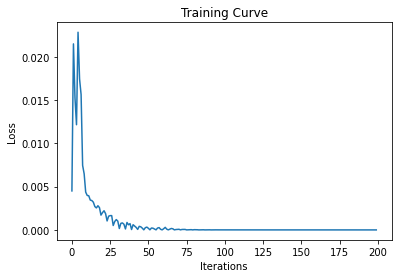

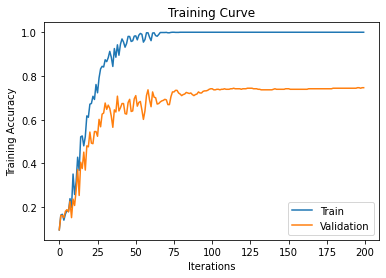

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7463768115942029


In [ ]:
# Initial
model = classification()
if use_cuda and torch.cuda.is_available():
  model.cuda()

train_class(model, train_feats, train_labels, batch_size = 512, num_epochs = 50, learning_rate = 0.001, use_cuda = use_cuda)

epoch:  20
epoch:  40
epoch:  50


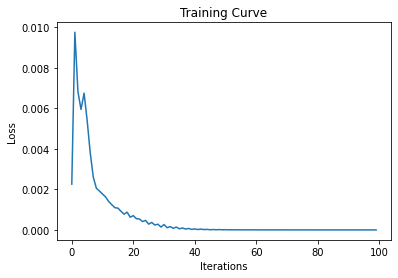

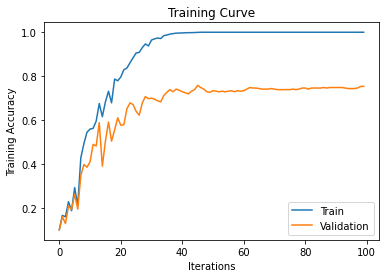

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7536231884057971


In [ ]:
# Increase batch size
model = classification()
if use_cuda and torch.cuda.is_available():
  model.cuda()

train_class(model, train_feats, train_labels, batch_size = 1024, num_epochs = 50, learning_rate = 0.001, use_cuda = use_cuda)

In [ ]:
# Save the best model
model_2a = classification()
model_path = check_point(model_2a.name, batch_size=1024, learning_rate=0.001, epoch=50)
state_2a = torch.load(model_path)
model_2a.load_state_dict(state_2a)

<All keys matched successfully>

The training curve shows that the model is able to learn from the dataset, but the valiadation accuray has not met our satisfaction(only 75%). We will continue work on this by tuning on different types of transfer learning and hyperparameters untill a satisfied result is obtained. We expect there are still improvements to make to increase the accuracy.